In [1]:
import sys
sys.path.append('../src')

import model.solar_radiation.solar_radiation_calculator as calc
from model.solar_radiation.solar_radiation_calculator import Location
import util.time_util as time_util

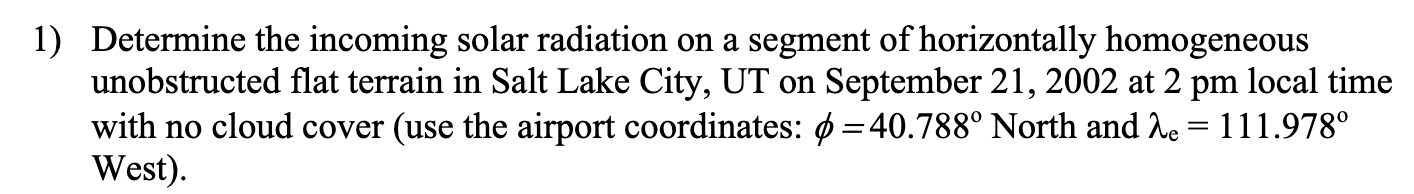

In [2]:
salt_lake_airport = Location(40.788, 111.978, "US/Mountain")
date_time = time_util.make_date_time(year=2002, month=9, day=21, hour=14, timezone=salt_lake_airport.timezone)
incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 769.45 W/m^2


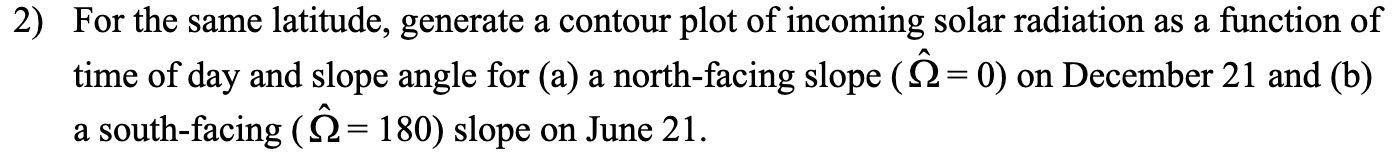

Text(0, 0.5, 'Time of Day (hours)')

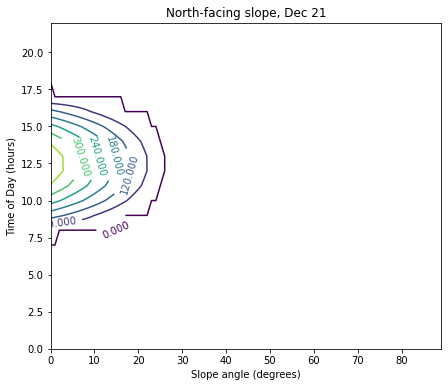

In [25]:
from matplotlib import pyplot as plt

hours = range(0, 23)
angles = range(0, 90)

times = [time_util.make_date_time(month=12, day=21, hour=hour, timezone=salt_lake_airport.timezone) for hour in hours]
incoming_shortwave = [[calc.calc_radiation_flux(date_time, salt_lake_airport, slope_azimuth=0, slope_angle=angle) 
                       for angle in angles]
                       for date_time in times]

fig, ax = plt.subplots(figsize=(7,6))
contour_plot = ax.contour(angles, hours, incoming_shortwave)
ax.clabel(contour_plot, inline=1, fontsize=10)
ax.set_title('North-facing slope, Dec 21')
ax.set_xlabel("Slope angle (degrees)")
ax.set_ylabel("Time of Day (hours)")

Text(0, 0.5, 'Time of Day (hours)')

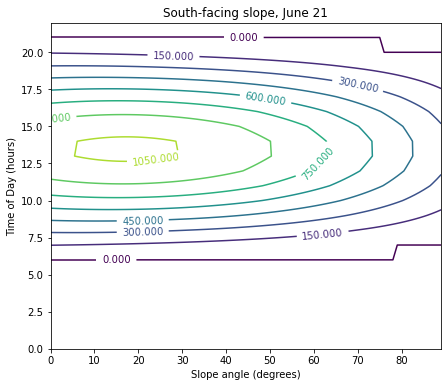

In [24]:
times = [time_util.make_date_time(month=6, day=21, hour=hour, timezone=salt_lake_airport.timezone) for hour in hours]
incoming_shortwave = [[calc.calc_radiation_flux(date_time, salt_lake_airport, slope_azimuth=180, slope_angle=angle) for angle in angles]
                       for date_time in times]

fig, ax = plt.subplots(figsize=(7,6))
contour_plot = ax.contour(angles, hours, incoming_shortwave)
ax.clabel(contour_plot, inline=1, fontsize=10)
ax.set_title('South-facing slope, June 21')
ax.set_xlabel("Slope angle (degrees)")
ax.set_ylabel("Time of Day (hours)")

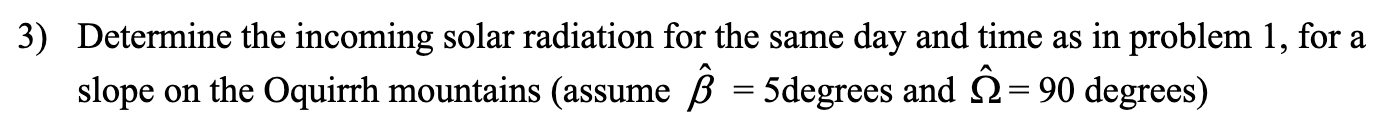

In [5]:
incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport, slope_angle=5, slope_azimuth=90)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 754.06 W/m^2


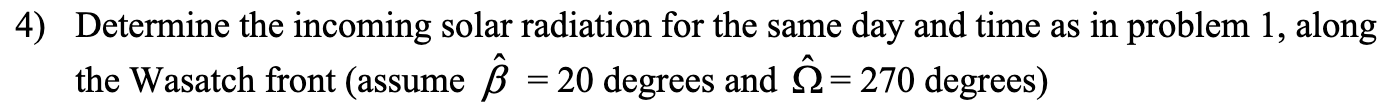

In [6]:
incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport, slope_angle=20, slope_azimuth=270)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 771.93 W/m^2


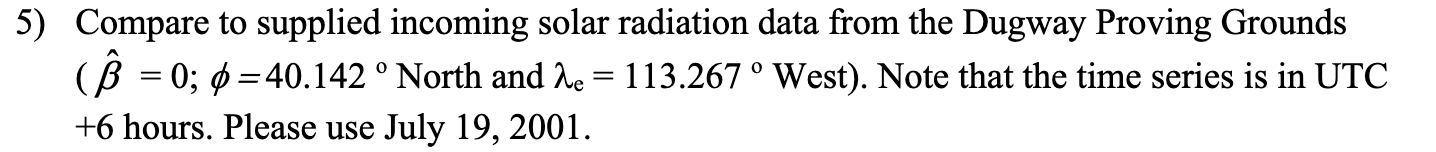

Text(0, 0.5, 'Radiative Flux (W/m^2)')

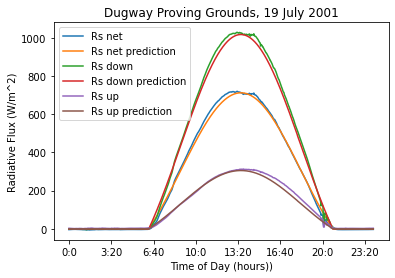

In [45]:
dugway = Location(40.142, 113.267, "US/Mountain") # Mountain Daylight Time is UTC+6
times = [time_util.make_date_time(month=6, day=21, hour=hour, timezone=salt_lake_airport.timezone) for hour in hours]

import pandas as pd

dugway_data = pd.read_csv("../data/raw/dugway.dat", sep="\t", header=4)
dugway_data["Rs net"] = dugway_data["Rs down"] - dugway_data["Rs up"]

def get_dugway_prediction(row, albedo=0):
    date_time = time_util.make_date_time(year=2001, month=int(row["Month"]), day=int(row["Day"]), 
                                        hour=int(row["Hour"]), minute=int(row["Minute"]), second=int(row["Second"]),
                                        timezone=dugway.timezone)
    return calc.calc_radiation_flux(date_time, dugway, albedo=albedo)

dugway_data["Rs down prediction"] = dugway_data.apply(get_dugway_prediction, axis=1)
dugway_data["Rs net prediction"] = dugway_data.apply(lambda x: get_dugway_prediction(x, albedo=.3), axis=1)
dugway_data["Rs up prediction"] = dugway_data["Rs down prediction"] - dugway_data["Rs net prediction"]

def format_number_string(number):
    return "{:.0f}".format(number)

def format_time(row):
    return ":".join([format_number_string((row["Hour"])), format_number_string(row["Minute"])])

dugway_data["Time"] = dugway_data.apply(format_time, axis=1)

ax = dugway_data[["Time","Rs net", "Rs net prediction", "Rs down", 
                  "Rs down prediction", "Rs up", "Rs up prediction"]].plot(x="Time")

ax.set_title('Dugway Proving Grounds, 19 July 2001')
ax.set_xlabel("Time of Day (hours))")
ax.set_ylabel("Radiative Flux (W/m^2)")

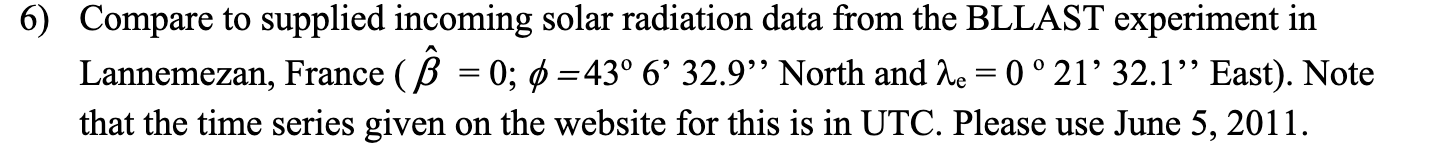

The day of year given is actually June 25th, I assume there's a typo in the question.

Text(0, 0.5, 'Radiative Flux (W/m^2)')

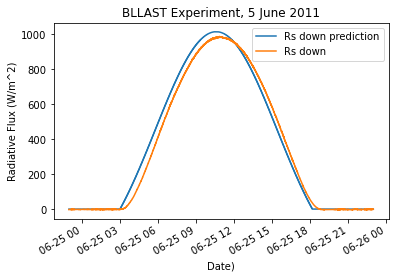

In [62]:
import scipy.io as sio
import numpy as np
bllast_data = sio.loadmat("../data/raw/BLLAST_IOP5.mat")
# print(bllast_data.keys())
bllast_data = pd.DataFrame(np.hstack((bllast_data['shortdownward'], bllast_data['date'])), 
                           columns=["Rs down", "date"])

bllast_data['date'] = pd.to_datetime(bllast_data['date'], unit='D',
                   origin=pd.Timestamp('2010-12-31')) + pd.Timedelta(hours=-1)

def get_bllast_prediction(row):
    lannemezan = Location(43, -21, "UTC")
    return calc.calc_radiation_flux(row['date'], lannemezan) #todo timezone inconsistent

bllast_data["Rs down prediction"] = bllast_data.apply(get_bllast_prediction, axis=1)

ax = bllast_data[["date", "Rs down prediction", "Rs down"]].plot(x="date")

ax.set_title('BLLAST Experiment, 5 June 2011')
ax.set_xlabel("Date)")
ax.set_ylabel("Radiative Flux (W/m^2)")